# Data Versioning

Keeping track of versions of your data can be tricky. Historically, data scientists might simply keep copies of all versions of data that they use, and rename them appropriately, which can clutter up your data store or file system, and makes it difficult to truly keep track of which data went with which model (experiment). 

The notion of having a data version control system, similar to what git does for code, has been around for awhile, and the most popular tools that have emerged to address these needs have been Git LFS and DVC. But, some would argue that using a version control tool for data is unnecessary, so long as the data scientist is disciplined enough to create reproducible data pipelines themselves, and so long as the data sources themselves are managed correctly. Regardless, I think it's useful to give data versioning a try, to understand its limitations.

## Data Version Control (DVC)

[DVC](https://dvc.org/) is a tool that can be used to track versions of data, and is used similarly to git. First, let's install DVC using 

`pip install dvc`  
`pip install dvc-s3`

from within your environment. There is no need to add this to your requirement.txt file, we are using it only for demonstration purposes. After it's installed you can check the version and help files:

`dvc -V`  
`dvc -h`

Then, in your project root folder you can initialize DVC, similar to initializing a git repo, using 

`dvc init` 

From here, you can see that there is a new .dvc folder and a .dvcignore file. The .dvcignore file is similar to .gitignore, you use it to tell DVC if there are certain data files you want DVC to ignore. The .dvc folder contains a config file and a tmp folder, and should also have a .gitignore file. This folder will eventually have a cache folder in it as well. We will talk about this in a minute. First, let's add the .dvc/config file and .dvcignore file to git. 

`git add .dvc/config .dvcignore .dvc/.gitignore`  or `git add .` might work if you don't have a bunch of other uncommited changes.  
`git commit -m 'add dvc'`  

You may want to push these to your Github repo at this point.

`git push origin main`  

Now you can start version-controlling data. Let's add a dataset to our data/ folder. You may already have data there, but you can also use any toy dataset that you want to use for practicing with DVC. I will add the adult.data file into my data/ folder and then add it to DVC (again, similar to git) using

`dvc add data/adult.data`

I can now see an adult.data.dvc file in the data/ folder. This file is important, and this is the one that we will keep under version control with git, so let's go ahead and add it now.

`git add data/adult.data.dvc`  
`git commit -m 'add adult data dvc file'`

And now feel free to take a look at what's in the adult.data.dvc file.

`cat data/adult.data.dvc`  

You will notice an md5 hash value. If you now go back to the .dvc folder you will now see a cache folder has been created. In the cache folder you will see a new folder in there with a name that should match the first couple of digits of the md5 hash value. Navigate into that folder and you'll see that adult.data is now in there.

`cd .dvc/cache/files/md5/{folder name}`  
`cat {file name}`  

This cache is important, it is how DVC will keep track of your different data versions.

To truly take advantage of data version control, we should store our data somewhere else, rather than locally. This way, your coworkers can access the same data. You can store the data in any number of cloud storage options. We may attempt to do this in a future lab.



### Simple Example

We can now modify our toy dataset, and *commit* and *push* those changes. I'm going to now add our `adult.test` data to the folder, and I'll go ahead and add it to DVC.

`dvc add data/adult.test`

Remember now to add the adult.test.dvc and any other changes you've made to your .gitignore files to your git repo. Then, push code changes to Github.

`git add data/.gitignore data/adult.test.dvc`  
`git commit -m 'add adult test data'`  
`git push origin main`  

Now, let's combine adult.data and adult.test. 

`wc -l data/adult.data`  
`cat data/adult.test >> data/adult.data`  
`wc -l data/adult.data`

The adult.data file has been modified. Let's add it to DVC and push the changes.

`dvc add data/adult.data`  
`git add data/adult.data.dvc`  
`git commit -m 'modify adult.data'`  
`git push origin main`   

Now suppose we want to roll back to a previous version of adult.data. We can use git to roll back to the previous version of adult.data.dvc, and then use DVC to checkout the previous version of the data.

`git checkout HEAD~1 data/adult.data.dvc`  
`dvc checkout`  

You can check that the old version of adult.data was checked out by running `wc -l data/adult.data` and noticing the word count matches what it was for the original data.

You can go back to the most recent version again by running `git checkout HEAD data/adult.data.dvc` and `dvc checkout`, but instead, let's keep the previous version and run with it.

`git commit -m 'revert to previous data version'`  
`git push origin main` 



### DVC Pipelines

A typical pipeline for a modeling experiment might have the following stages:

- Import data and create train/validation/test splits   
- Clean data and create features  
- Model training  
- Model evaluation

DVC is capable of keeping track of an entire pipeline like this, though for our purposes we will not include model training and evaluation. 

We've already created the first stage of our pipeline when we added our train and test datasets to DVC. To create the next stage in the data pipeline using DVC, we will create a script that reads in our train and test datasets, makes some changes, and outputs two new datasets for use later. We call this script `create_features.py`. This script loads the data, uses a Pipeline (from sklearn) to transform the data, writes the Pipeline to `pipeline.pkl` and the two transformed data sets to `processed_train_data.csv` and `processed_test_data.csv`. 

We can use DVC to create this new *stage* in our pipeline. DVC will run the code in `create_features.py`. We can create pipelines by specifying them in a `dvc.yaml` file. So, let's create a `dvc.yaml` file in the root directory of our project and add the following pipeline to it.

```
stages:
  prepare:
    cmd: python src/create_features.py
    deps:
      - data/adult.data
      - data/adult.test
      - src/create_features.py
    outs:
      - data/pipeline.pkl
      - data/processed_train_data.csv
      - data/processed_test_data.csv
```

You'll notice that we list out all of the file dependencies that are needed to run our `create_features.py` script, as well as everything that is output from the script. After creating the `dvc.yaml` file we can run `dvc stage list` to see that the *prepare* stage was created.

Now, we can run the pipeline using

`dvc repro`

Once the pipeline is run, we will see several things happen automatically: the outputs of the pipeline will be in the `data` folder, a new file called `dvc.lock` will appear in the root project folder, and the outputs from the pipeline will be added to the `data/.gitignore` file. Take a look at the `dvc.lock` and `data/.gitignore` file before moving on.

From here, you should add the new `dvc.lock`, `dvc.yaml`, and the `data/.gitignore` to the git repo, as well as the create_features.py script. Then commit and push to Github. 

### Parameters

Suppose your pipeline depends on a set of parameters, for example a random seed for doing train/test splits. We can place those parameter values in a **params.yaml** file, and use DVC and git to keep track of changes to these parameters. We would need to change our script to include the yaml file and set the parameters.

Create a params.yaml file that looks like this:
```
features:  
    chi2percentile: 50
    train_path: data/adult.data  
    test_path: data/adult.test
```
Then change the script so that the percentile used for feature selection reads from the yaml file instead of being hard-coded:

`import yaml`  
`params = yaml.safe_load(open("params.yaml"))["features"]`  
`chi2percentile = params["chi2percentile"]`  

and update this line:

`("selector", SelectPercentile(chi2, percentile=chi2percentile)),`

I've included a new version of the script, called `create_features_w_params.py` that you can use for this instead. Now, we'll want to replace the previous pipeline we created in our `dvc.yaml` file by using this new pipeline with parameters. We can simply add the following within our pipeline:

```
params: 
      - features.chi2percentile
      - features.train_path
      - features.test_path
```

Now, run `dvc repro` to see if it works.

When you create pipelines using DVC, you can easily reproduce entire pipelines by running `dvc repro`. For example, if we accidentally changed or deleted one of the output files, such as `data/processed_test_data.csv`, we can simply run `dvc repro` to get it back. In fact, delete both output files and run `dvc repro`. DVC will automatically grab both output files from the cache without needing to rerun the entire script to recreate them.



### DVC Recap

We've shown that we can use DVC to keep track of data versions and pipelines:

- Initialize DVC, similar to a git repository  
- Add datasets to DVC so they are tracked  
- Use git to keep track of the versions of the data through the `{data_name}.dvc` files   
- Roll back to previous versions of data using git  
- Create reproducible pipelines with or without parameters by adding `stages` and using `repro`  

DVC actually does a whole lot more than this, some of which overlaps with other tools. 



## Reproducible Pipelines

If you don't want to learn how to use DVC, or if it doesn't seem useful, you can instead ensure you can reproduce your data with code. The key here is that each dataset you create, including intermediate datasets, should be reproducible by running a script, with optional parameters. Suppose you create intermediate dataset D1, and then you join D1 with another dataset and create D2, and then you do some feature engineering and transformations that result in a final dataset D3. You code should be written in a way such that you can run the script and recreate the exact same D1, D2, and D3 datasets.

There are necessary conditions for this, such as your data sources (the raw source of data that your pipeline begins with) should remain static in some way. The initial data sources should still be the same, i.e. you should be able to pull the exact same data without worrying about the schema, data types, column names, changing data values, etc.. If the source of the data suddenly has 10 additional columns, and the data has been changed or updated over time, then your intermediate and final datasets will likely be different or difficult to reproduce.

Note that you should be able to track any parameter values you use when you run the pipeline. It doesn't help to write reproducible pipelines if you can't remember what parameter values created which versions of the data.

Our **create_features.py** script attempts to create a reproducible pipeline using the Pipeline class from sklearn, but there are several improvements we can make.

1. Create functions for each step, with parameters that make sense (e.g. the column names list, file paths) and put these at the top of the script  
2. Call these functions at the bottom after `if __name__ == "__main__":` 

### Orchestration Engines

To run a data pipeline there are several tools available that are especially useful for data management, such as [Airflow](https://airflow.apache.org/), [Prefect](https://www.prefect.io/), and [Dagster](https://dagster.io/). So. Many. Tools. These tools are what you would use to create proper production-grade data pipelines. 

### Getting Started with Prefect

Just for fun we'll get started with Prefect, for free. You will need to sign up at [https://www.prefect.io/](https://www.prefect.io/) to try Prefect cloud.

From here, just follow the instructions given to you in the browser (copied below for your reference).

1. Connect your terminal to Prefect Cloud by running   
    `pip install -U prefect`  
    `prefect cloud login`  
2. Choose **Log in with a web browser**.  
3. Copy and paste the below code into a file called `hello_world.py`. Save it in a `src/` folder, or wherever you are saving your scripts.  
4. Run: `python3 hello_world.py`  
5. From the web UI go to **Trigger a new run**. 

In [ ]:
from prefect import flow


@flow(log_prints=True)
def hello_world(name: str = "world", goodbye: bool = False):
    print(f"Hello {name} from Prefect! 🤗")

    if goodbye:
        print(f"Goodbye {name}!")


if __name__ == "__main__":
    hello_world.serve(name="my-first-deployment",
                      tags=["onboarding"],
                      parameters={"goodbye": True},
                      interval=60)

If you have time, you should play around a little more with Prefect (in case we are unable to cover this tool later in the course). You can also go through a quick tutorial [here](https://docs.prefect.io/latest/tutorial/). In this class we will create ML workflows using a different tool called Metaflow, which is specific for machine learning, but then Prefect can be used for scheduling purposes, and to orchestrate the ML flow with the rest of the pipeline.

# Data Versioning Lab

## Overview

In this lab you will practice using DVC to create data pipelines.

## Goal

The goal in this lab is to become familiar with the importance of keeping track of different versions of your data sets. Although we will use DVC in this lab, we are **not** trying to learn all we can about it. DVC has too much functionality for us to learn in a single lab. 

## Instructions

Using the data that you used in the Experiment Tracking lab, use DVC to create a reproducible pipeline for data preprocessing. 
 
- Put your datasets in a `data/` folder  
- Add your datasets to DVC  

At this point you should create a script, called `preprocessing.py`, saved to the `src/` folder, that does only the data preprocessing stages of the pipeline. Any modeling stages can be kept in a separate script. You may need to first work inside of a notebook to finalize your code. Feel free to just copy and paste any data processing code that you previously used on Lab 2.  

Once your script works, 

- in the root directory of your project, create the `dvc.yaml` file. The `params.yaml` file is optional.  
- run `dvc repro` to create the output files.  
- commit and push changes to Github.  
- remember, do not add your data files to git.

To get credit for this lab, I should be able to see that you've created a pipeline for your project data. There should be: 

- a preprocessing.py file in the `src/` directory,  
- *.dvc files for your datasets in the `data/` directory,     
- dvc.lock and dvc.yaml files in the root directory,    
- an optional params.yaml in the root directory.

### Turning It In

As before, send me a link, in Canvas, to your Github repo. Even though you may have done this already, please do so again to indicate you have finished the lab.

Here's a screenshot of me having run the data specifically with my chocolate files:
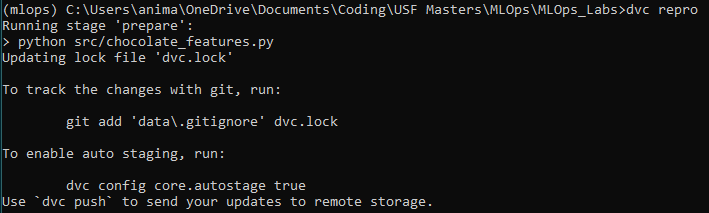